## PROJECT OBJECTIVE:To build a digit classifier on the SVHN (Street View Housing Number) dataset.

### Part B - 30 Marks

### DOMAIN: Autonomous Vehicles

CONTEXT: A Recognising multi-digit numbers in photographs captured at street level is an important component of modern-day map
making. A classic example of a corpus of such street-level photographs is Google’s Street View imagery composed of hundreds of millions
of geo-located 360-degree panoramic images.
The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a
known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. More broadly, recognising
numbers in photographs is a problem of interest to the optical character recognition community.
While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is
still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large
range of fonts, colours, styles, orientations, and character arrangements.
The recognition problem is further complicated by environmental factors such as lighting, shadows, specularity, and occlusions as well as
by image acquisition factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred around
a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simpler,
it is more complex than MNIST because of the distractors.

DATA DESCRIPTION: The SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with the
minimal requirement on data formatting but comes from a significantly harder, unsolved, real-world problem (recognising digits and
numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.
Where the labels for each of this image are the prominent number in that image i.e. 2,6,7 and 4 respectively.
The dataset has been provided in the form of h5py files. You can read about this file format here: https://docs.h5py.org/en/stable/
Acknowledgement: Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised
Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. PDF
http://ufldl.stanford.edu/housenumbers as the URL for this site.

## 1. Data Import and Exploration [5 Marks]

In [1]:
# Import All Dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
import random
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

seed = 7
np.random.seed(seed)
warnings.filterwarnings("ignore")
%matplotlib inline

### A. Read the .h5 file and assign to a variable. [2 Marks]

In [2]:
import h5py

In [3]:
# Open the file as readonly
h5f = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')

### B. Print all the keys from the .h5 file. [1 Marks]

In [4]:
h5f.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

### C. Split the data into X_train, X_test, Y_train, Y_test [2 Marks]

In [5]:
# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

## 2. Data Visualisation and preprocessing [13 Marks]

### A. Print shape of all the 4 data split into x, y, train, test to verify if x & y is in sync. [1 Marks]

In [6]:
print("Shape for X_train: {}".format(X_train.shape))
print("Shape for y_train: {}".format(y_train.shape))
print("Shape for X_test: {}".format(X_test.shape))
print("Shape for y_test: {}".format(y_test.shape))

Shape for X_train: (42000, 32, 32)
Shape for y_train: (42000,)
Shape for X_test: (18000, 32, 32)
Shape for y_test: (18000,)


- Data is perfectly Sync in train test 
- 42000 images of shape 32 * 32 in train and  18000 images for test

### B. Visualise first 10 images in train data and print its corresponding labels. [4 Marks]

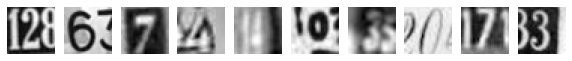

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [7]:

# visualizing the first 10 images in the dataset and their labels

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

### C. Reshape all the images with appropriate shape update the data in same variable. [3 Marks]

In [8]:
# Reshaping the dataset to flatten them. Remember that we are trying to reshape the 2D image data into a 1D array

X_train = X_train.reshape(X_train.shape[0], 1024, 1)
X_test = X_test.reshape(X_test.shape[0], 1024, 1)

print("Train Shape: {}".format(X_train.shape))
print("Test Shape: {}".format(X_test.shape))

Train Shape: (42000, 1024, 1)
Test Shape: (18000, 1024, 1)


- Need to reshape the X_train and X_test so that the same can be fed for model building. Currently we have a 2D tensor and we need to feed a 1D tensor into the model.

### D. Normalise the images i.e. Normalise the pixel values. [2 Marks]

In [9]:
# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
print('Resized Training set', X_train.shape, y_train.shape)
print('Resized Test set', X_test.shape, y_test.shape)

Resized Training set (42000, 1024, 1) (42000,)
Resized Test set (18000, 1024, 1) (18000,)


### E. Transform Labels into format acceptable by Neural Network [2 Marks]

In [11]:
# one hot encode outputs
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


### F. Print total Number of classes in the Dataset. [1 Marks]

In [12]:
# no.of classes
num_classes = y_train_encoded.shape[1] 
print("The number of classes in this dataset are:",num_classes)

The number of classes in this dataset are: 10


## 3. Model Training & Evaluation using Neural Network [12 Marks]

### A. Design a Neural Network to train a classifier. [3 Marks]

In [13]:
# define model

Model = Sequential()

# The Input Layer :
Model.add(Dense(units=128, 
                   kernel_initializer='normal',
                   input_shape=(1024,),
                   activation='relu'))

# The Hidden Layers :
 

Model.add(Dense(units=64, 
                   kernel_initializer='normal',
                   activation='relu')) 

Model.add(Dense(units=32, 
                   kernel_initializer='normal'))
Model.add(LeakyReLU(alpha=0.1))

Model.add(Dense(units=16, 
                   kernel_initializer='normal'))
Model.add(LeakyReLU(alpha=0.1))


# The Output Layer :
Model.add(Dense(units=num_classes, 
                   kernel_initializer='normal',
                   activation="softmax"))  # this is regression so will use linear activation function 

In [14]:
# Compile the network :
Model.compile(optimizer = 'adam', 
                 loss = 'categorical_crossentropy',
                 metrics=["accuracy"])


Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                1

### B. Train the classifier using previously designed Architecture (Use best suitable parameters). [3 Marks]

In [15]:
EPOCHS = 200
history = Model.fit(X_train,
                      y_train_encoded,
                      batch_size=256 , 
                      epochs=EPOCHS , 
                      validation_split=0.2,
                      verbose = 1)

# save trained model
Model.save("Image_Classification_Model.h5")

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/132 [============================>.] - ETA: 0s - loss: 2.3027 - accuracy: 0.0993WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000266B1F9B1F8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

132/132 [==============================] - 1s 10ms/step - loss: 0.9192 - accuracy: 0.7143 - val_loss: 0.9482 - val_accuracy: 0.7080
Epoch 45/200
132/132 [==============================] - 1s 9ms/step - loss: 0.9072 - accuracy: 0.7163 - val_loss: 0.9818 - val_accuracy: 0.6920
Epoch 46/200
132/132 [==============================] - 1s 11ms/step - loss: 0.9075 - accuracy: 0.7160 - val_loss: 0.9466 - val_accuracy: 0.7093
Epoch 47/200
132/132 [==============================] - 1s 11ms/step - loss: 0.8950 - accuracy: 0.7179 - val_loss: 0.9465 - val_accuracy: 0.7086
Epoch 48/200
132/132 [==============================] - 1s 9ms/step - loss: 0.8849 - accuracy: 0.7250 - val_loss: 0.9343 - val_accuracy: 0.7132
Epoch 49/200
132/132 [==============================] - 1s 10ms/step - loss: 0.8715 - accuracy: 0.7282 - val_loss: 0.9311 - val_accuracy: 0.7126
Epoch 50/200
132/132 [==============================] - 1s 9ms/step - loss: 0.8698 - accuracy: 0.7292 - val_loss: 0.9319 - val_accuracy: 0.7108
E

Epoch 101/200
132/132 [==============================] - 1s 8ms/step - loss: 0.6384 - accuracy: 0.8028 - val_loss: 0.7564 - val_accuracy: 0.7696
Epoch 102/200
132/132 [==============================] - 1s 8ms/step - loss: 0.6551 - accuracy: 0.7940 - val_loss: 0.7744 - val_accuracy: 0.7593
Epoch 103/200
132/132 [==============================] - 1s 8ms/step - loss: 0.6525 - accuracy: 0.7964 - val_loss: 0.7945 - val_accuracy: 0.7606
Epoch 104/200
132/132 [==============================] - 1s 9ms/step - loss: 0.6338 - accuracy: 0.8015 - val_loss: 0.7562 - val_accuracy: 0.7724
Epoch 105/200
132/132 [==============================] - 1s 8ms/step - loss: 0.6348 - accuracy: 0.8032 - val_loss: 0.7603 - val_accuracy: 0.7658
Epoch 106/200
132/132 [==============================] - 1s 10ms/step - loss: 0.6376 - accuracy: 0.8011 - val_loss: 0.7475 - val_accuracy: 0.7796
Epoch 107/200
132/132 [==============================] - 1s 10ms/step - loss: 0.6390 - accuracy: 0.8022 - val_loss: 0.7525 - val_

132/132 [==============================] - 1s 8ms/step - loss: 0.5446 - accuracy: 0.8301 - val_loss: 0.7315 - val_accuracy: 0.7836
Epoch 158/200
132/132 [==============================] - 1s 9ms/step - loss: 0.5527 - accuracy: 0.8285 - val_loss: 0.7077 - val_accuracy: 0.7881
Epoch 159/200
132/132 [==============================] - 2s 11ms/step - loss: 0.5467 - accuracy: 0.8296 - val_loss: 0.7303 - val_accuracy: 0.7838
Epoch 160/200
132/132 [==============================] - 2s 11ms/step - loss: 0.5412 - accuracy: 0.8328 - val_loss: 0.6999 - val_accuracy: 0.7957
Epoch 161/200
132/132 [==============================] - 1s 5ms/step - loss: 0.5402 - accuracy: 0.8317 - val_loss: 0.7083 - val_accuracy: 0.7912
Epoch 162/200
132/132 [==============================] - 1s 4ms/step - loss: 0.5294 - accuracy: 0.8346 - val_loss: 0.7080 - val_accuracy: 0.7914
Epoch 163/200
132/132 [==============================] - 1s 4ms/step - loss: 0.5417 - accuracy: 0.8323 - val_loss: 0.7150 - val_accuracy: 0.78

### C. Evaluate performance of the model with appropriate metrics. [2 Marks]

In [16]:
# check scores
score, acc = Model.evaluate(X_train, y_train_encoded,
                            batch_size=10)

# prediction on test Data
y_pred_prob =  Model.predict(X_test)

# convert probablites into index label
y_pred = [ np.argmax(i)  for i in y_pred_prob]

print("-----------------------Scores--------------------------")

print("First Model Performance: ")
print('Train score:', score)
print('Train accuracy:', acc)

4200/4200 [==============================] - 10s 2ms/step - loss: 0.5387 - accuracy: 0.8342
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
563/563 [==============================] - 1s 2ms/step
-----------------------Scores--------------------------
First Model Performance: 
Train score: 0.5387343168258667
Train accuracy: 0.8342142701148987


In [17]:
print("-------------------Confusion Matrix---------------------")
print(confusion_matrix(y_pred,y_test))
print()
print("------------------Classificatin Report-------------------")
print(classification_report(y_pred,y_test))
print()
print("------------------Accuracy Scores-------------------")
print(accuracy_score(y_pred,y_test))
print()

-------------------Confusion Matrix---------------------
[[1486   25   18   16   26   14   37   10   23   58]
 [  79 1554   54   71   64   28   36  104   62   51]
 [  17   17 1411   58   36   10   17   54   27   29]
 [  23   31   46 1227   25   83   18   17   58   55]
 [  64   63   34   26 1533   20   59   17   46   30]
 [  11   11   21  157   21 1412   99   10   72   85]
 [  37   13    8   13   34   84 1455   10  111   14]
 [  37   83  136   42   13   20   14 1541   15   35]
 [  11    9   29   59   24   54   74   11 1319   58]
 [  49   22   46   50   36   43   23   34   79 1389]]

------------------Classificatin Report-------------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1713
           1       0.85      0.74      0.79      2103
           2       0.78      0.84      0.81      1676
           3       0.71      0.78      0.74      1583
           4       0.85      0.81      0.83      1892
           5       0.80     

### D. Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your observations on the same. [4 Marks]

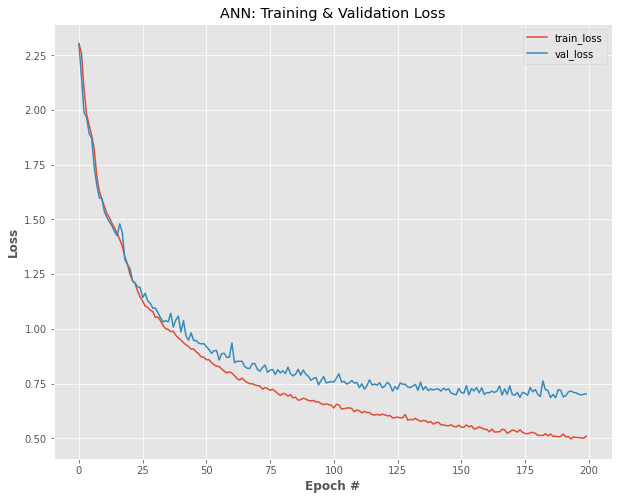

In [18]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("ANN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

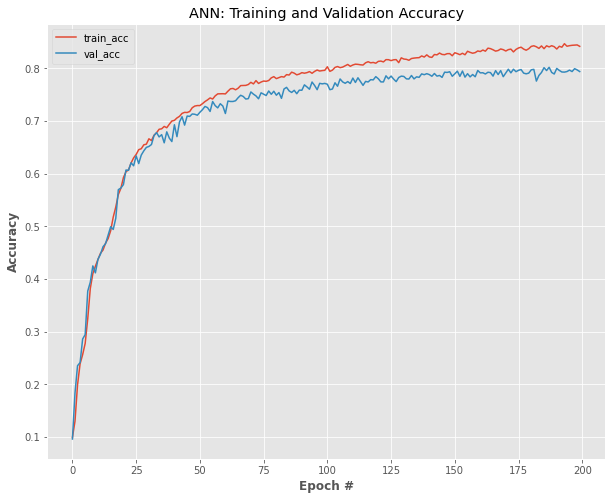

In [19]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("ANN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

# Conlusion and Observation 

- There are around 10 classes in the dataset which represent digits from 0-9.

- We tried training a Neural Network with dense hidden layers of different number of units and are able to achieve a final test accuracy of 80.74 %.

-  Also we notice that after a certain point the model begins to overfit on our dataset as is clear from the plots above where the validation loss and val accuracy fluctuating liltle bit but its not increasing 


- The classification report tells us that numbers 0 and 4 have the highest f1-score (0.84) meaning they have the best chances of being accurately recognized. Whereas, numbers 3 and 8 have the lowest f1-score of (0.77).

- Number 3 has the lowest precision and 1 and 7 has the highest, this means that the model is classifing other numbers as 3 which not valid. Whereas 1 and 7 has the lowest chances of being invalidly positive.

- Number 0 has the highest recall, whereas 1 and 5 have the lowest. It indicates that the model is struggling to identify all 5's and 1's as what they are. Opposed to 0, which the model idenifies in high rates of completion.



- So based on all observation we can conclude that there is still lot of scope for model improvemnet
- We can use few more layers with batch normalization technique 
- we can also use pretrained model like VGG16 which will definetly give better accuracy


Note: Image is unsturctre data and spatial data so ANN is not suitable for image data, so insted of ANN we have to use CNN archtecture which works better on Image data 

# THE END 